In [1]:
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import OrderedDict

In [2]:
import sys; sys.path.append('.')
from pyqg_subgrid_dataset import PYQGSubgridDataset

In [3]:
torch.cuda.current_device()

0

In [21]:
def basic_cnn(input_shape, output_shape):
    return nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, input_shape)),
            ('conv1', nn.Conv2d(input_shape[0], 32, 5)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(2)),
            ('conv2', nn.Conv2d(32, 32, 5)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(2)),
            ('flat', nn.Flatten()),
            ('fc1', nn.Linear(800, 256)),
            ('fc1_relu', nn.ReLU()),
            ('fc2', nn.Linear(256, np.product(output_shape)))
        ]))

In [5]:
pyqg = PYQGSubgridDataset(data_dir='/scratch/zanna/data/pyqg/single_run_all_steps')

In [11]:
inputs = pyqg.dataset.coarse_data.potential_vorticity.data.astype(np.float32).reshape(-1,32*32)
targets = pyqg.dataset.forcing_data.potential_vorticity.data.astype(np.float32).reshape(-1,32*32)

inputs.shape

(86400, 1024)

In [12]:
input_mu = inputs.mean()
input_sd = inputs.std()
target_mu = targets.mean()
target_sd = targets.std()

input_mu, input_sd, target_mu, target_sd

(2.814315e-07, 2.3936675e-06, -6.0759735e-12, 6.024838e-12)

In [13]:
inputs = (inputs - input_mu) / input_sd
targets = (targets - target_mu) / target_sd

In [14]:
inputs.mean(), inputs.std(), targets.mean(), targets.std()

(-9.670136e-06, 0.99999416, -2.044191e-06, 0.9999998)

In [22]:
cnn = basic_cnn((1, 32, 32), (1, 32, 32))

In [23]:
def train(net, inputs, targets, num_epochs=5, batch_size=64, learning_rate=0.001):
    assert len(inputs) == len(targets)
    order = np.arange(len(inputs))
    steps_per_epoch = len(inputs) // batch_size
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        np.random.shuffle(order)
        epoch_loss = 0.0
        
        for step in range(steps_per_epoch):
            idx = order[step*batch_size:(step+1)*batch_size]
            
            x = torch.as_tensor(inputs[idx])
            y = torch.as_tensor(targets[idx])
            optimizer.zero_grad()
            yhat = net(x)
            
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        print(f"Loss after Epoch {epoch+1}: {epoch_loss/steps_per_epoch}")

In [24]:
order = np.arange(len(inputs))
np.random.shuffle(order)
split_at = int(len(inputs)*3/4)
train_idx = order[:split_at]
test_idx = order[split_at:]

In [25]:
train(cnn, inputs[train_idx], targets[train_idx])

Loss after Epoch 1: 0.19145953416706546
Loss after Epoch 2: 0.18533096880663052
Loss after Epoch 3: 0.18507627198995338
Loss after Epoch 4: 0.18489464538782951
Loss after Epoch 5: 0.18485592120131955


In [31]:
preds = cnn(torch.as_tensor(inputs[test_idx[:64]])).data.numpy()

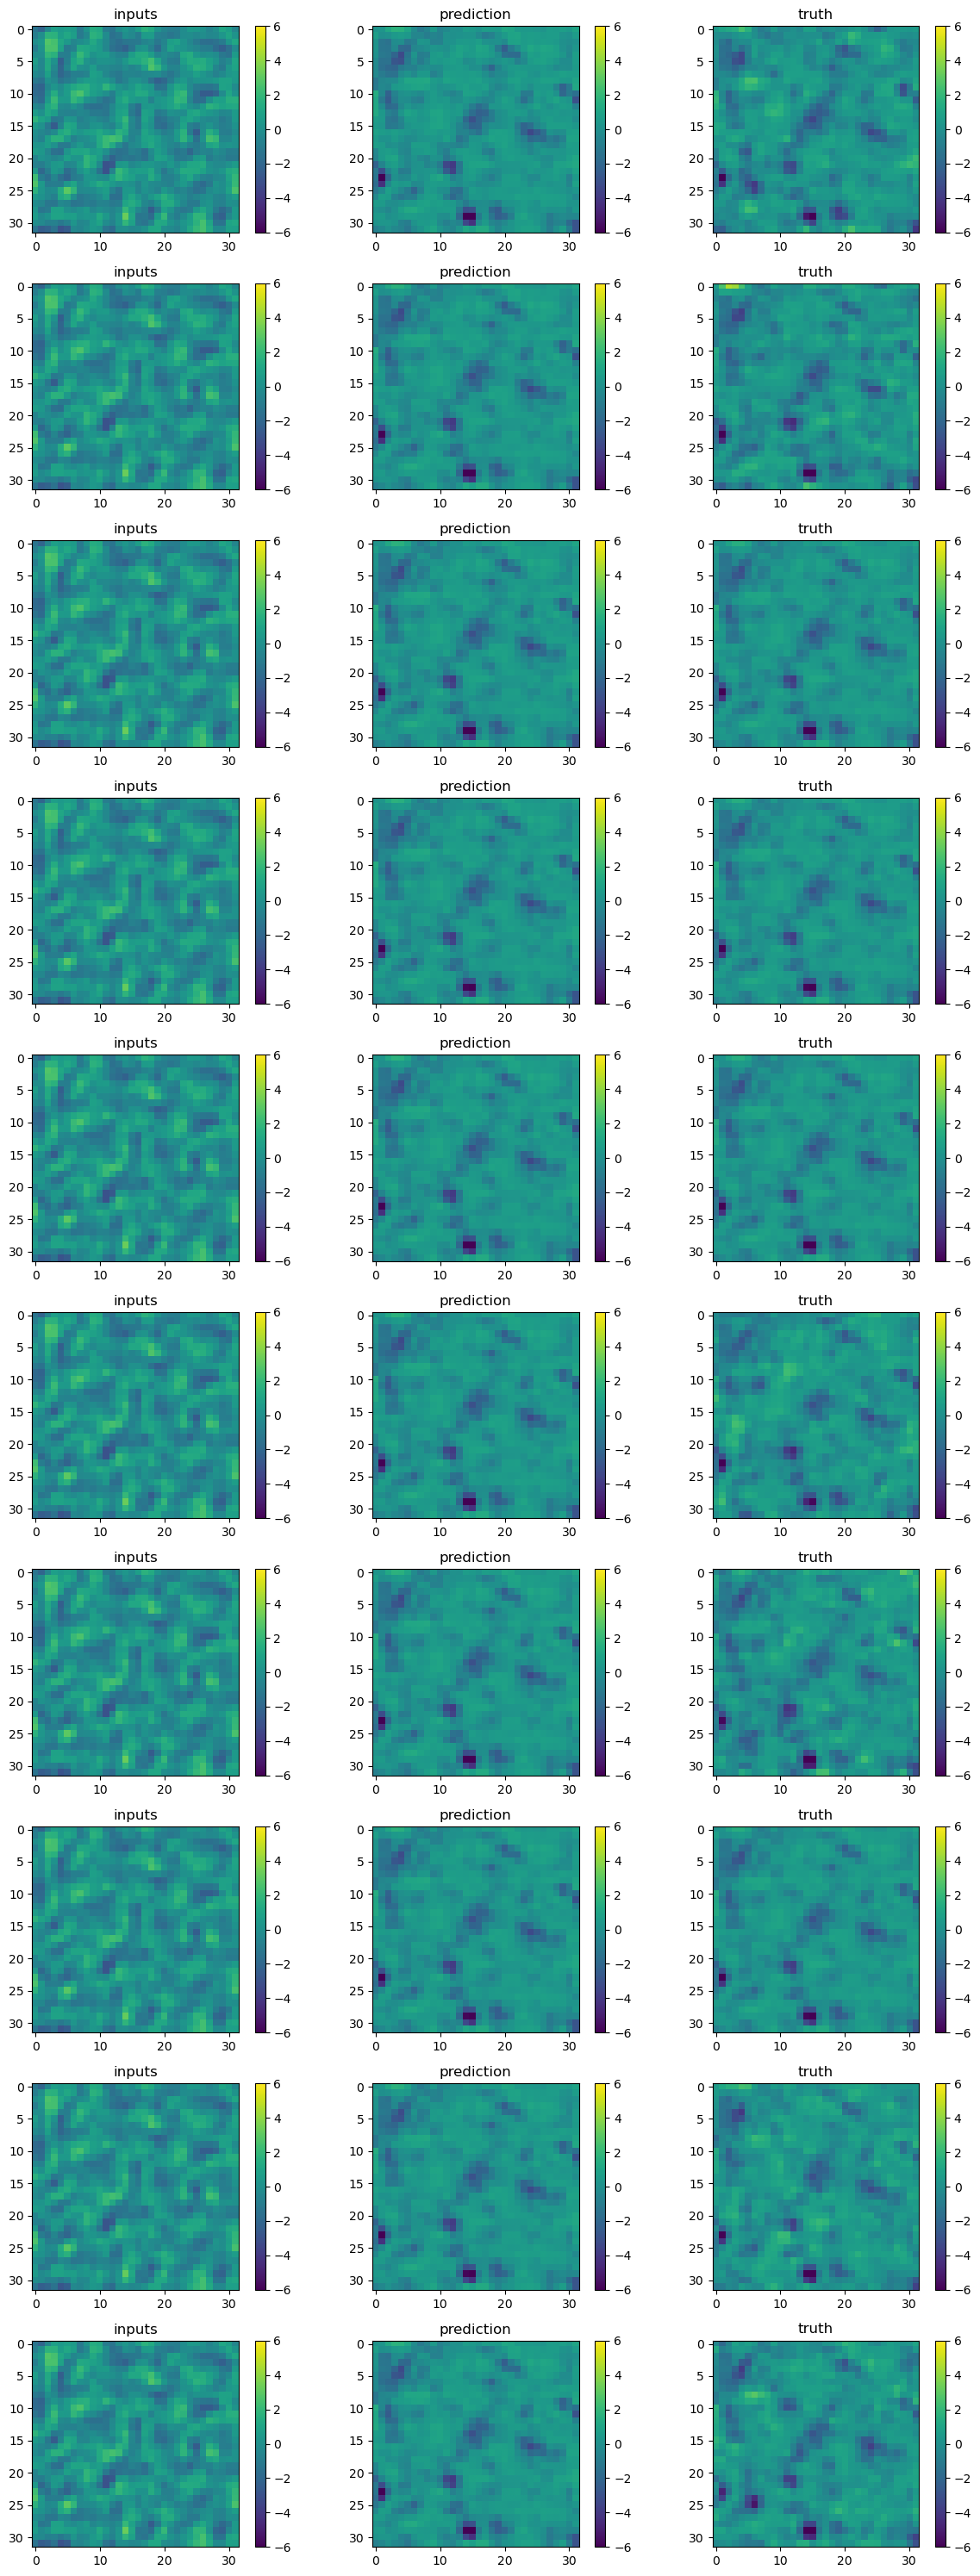

In [40]:
with figure_grid(10,3) as g:
    for i in range(10):
        g.next(title='inputs')
        plt.imshow(inputs[test_idx[i]].reshape(32,32), vmin=-6, vmax=6)
        plt.colorbar()
        
        g.next(title='prediction')
        plt.imshow(preds[i].reshape(32,32), vmin=-6, vmax=6)
        plt.colorbar()
        
        g.next(title='truth')
        plt.imshow(targets[test_idx[i]].reshape(32,32), vmin=-6, vmax=6)
        plt.colorbar()

In [36]:
import matplotlib.pyplot as plt
class figure_grid():
    def next_subplot(self, title=None, **kwargs):
        if self.next_title is not None:
          plt.title(self.next_title)
        self.subplots += 1
        self.next_title = title
        return self.fig.add_subplot(self.rows, self.cols, self.subplots, **kwargs)

    def each_subplot(self):
        for _ in range(self.rows * self.cols):
            yield self.next_subplot()

    def title(self, title, fontsize=16, y=1.0, **kwargs):
        self.fig.suptitle(title, y=y, fontsize=fontsize, va='bottom', **kwargs)

    def __init__(self, rows, cols, rowheight=3, rowwidth=12, after_each=lambda: None, filename=None):
        self.rows = rows
        self.cols = cols
        self.fig = plt.figure(figsize=(rowwidth, rowheight*self.rows))
        self.subplots = 0
        self.next_title = None
        self.filename = filename

    def __enter__(self):
        return self

    def __exit__(self, _type, _value, _traceback):
        if self.next_title is not None:
          plt.title(self.next_title)
        if self.filename:
            try:
                plt.tight_layout()
                plt.savefig(self.filename, bbox_inches='tight')
            except:
                print("ERROR SAVING FIGURE")
            plt.close(self.fig)
        else:
            plt.tight_layout()
            plt.show()

    next = next_subplot